# Preprocessing & Training

### Goal:
<p>Create a cleaned development dataset you can use to complete the modeling step of your project.</p>

### Steps:
<ul><li>Create dummy or indicator features for categorical variables</li><li>Standardize the magnitude of numeric features using a scaler</li><li>Split into testing and training datasets</li></ul>
Review the following questions and apply them to your dataset:<ul><li>Does my data set have any categorical data, such as Gender or day of the week?</li><li>Do my features have data values that range from 0 - 100 or 0-1 or both and more?  </li></ul>

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from library.sb_utils import save_file

In [2]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
adopted = pd.read_csv('data/dogs_trimmed.csv')
adopted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7179 entries, 0 to 7178
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    7179 non-null   object 
 1   gender                 7179 non-null   object 
 2   size                   7179 non-null   object 
 3   coat                   7179 non-null   object 
 4   distance               7179 non-null   float64
 5   spayed_neutered        7179 non-null   bool   
 6   house_trained          7179 non-null   bool   
 7   special_needs          7179 non-null   bool   
 8   shots_current          7179 non-null   bool   
 9   breed_primary          7179 non-null   object 
 10  breed_secondary        7179 non-null   object 
 11  breed_mixed            7179 non-null   bool   
 12  color_primary          7179 non-null   object 
 13  color_secondary        7179 non-null   object 
 14  color_tertiary         7179 non-null   object 
 15  good

## Dummies!
### After converting bools to ints, of course

In [4]:
df = adopted[['gender', 'size', 'coat', 'duration_as_adoptable', 'hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'special_needs', 'shots_current', 'goodwith_children', 'goodwith_dogs', 'goodwith_cats']]
df.loc[:, ['hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'special_needs', 'shots_current']] = adopted.loc[:, ['hasimage', 'hasvideo', 'spayed_neutered', 'house_trained', 'special_needs', 'shots_current']].astype('int64')
df = pd.get_dummies(df)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
# drop one of each of the dummy category columns so those features don't double-weight anything
df.drop(['size_Extra Large', 'gender_Female', 'coat_Hairless', 'goodwith_children_False', 'goodwith_dogs_False', 'goodwith_cats_False'], axis=1, inplace=True)

## Imputing Values

In [6]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed = imp.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

## Scaling using StandardScaler()

In [7]:
X = df.drop(columns='duration_as_adoptable')
y = df.duration_as_adoptable

scaler = StandardScaler()
scaled = scaler.fit_transform(X)

In [9]:
scaled_X = pd.DataFrame(scaled, columns=X.columns)
scaled_X.describe()

,hasimage,hasvideo,spayed_neutered,house_trained,special_needs,shots_current,gender_Male,size_Large,size_Medium,size_Small,coat_Curly,coat_Long,coat_Medium,coat_Short,coat_Wire,coat_unknown,goodwith_children_True,goodwith_children_unknown,goodwith_dogs_True,goodwith_dogs_unknown,goodwith_cats_True,goodwith_cats_unknown
count,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000,7179.00000
mean,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000
std,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007,1.00007
min,-8.24796,-0.20295,-1.77474,-0.84534,-0.17402,-3.45810,-1.05633,-0.59735,-0.72447,-0.77941,-0.12589,-0.25614,-0.54392,-1.05367,-0.14103,-0.41713,-0.85824,-0.98356,-1.26237,-0.73793,-0.62833,-1.23031
25%,0.12124,-0.20295,0.56346,-0.84534,-0.17402,0.28918,-1.05633,-0.59735,-0.72447,-0.77941,-0.12589,-0.25614,-0.54392,-1.05367,-0.14103,-0.41713,-0.85824,-0.98356,-1.26237,-0.73793,-0.62833,-1.23031
50%,0.12124,-0.20295,0.56346,-0.84534,-0.17402,0.28918,0.94668,-0.59735,-0.72447,-0.77941,-0.12589,-0.25614,-0.54392,0.94906,-0.14103,-0.41713,-0.85824,-0.98356,0.79216,-0.73793,-0.62833,0.81281
75%,0.12124,-0.20295,0.56346,1.18296,-0.17402,0.28918,0.94668,1.67405,1.38033,1.28302,-0.12589,-0.25614,-0.54392,0.94906,-0.14103,-0.41713,1.16518,1.01672,0.79216,1.35515,1.59153,0.81281
max,0.12124,4.92729,0.56346,1.18296,5.74662,0.28918,0.94668,1.67405,1.38033,1.28302,7.94344,3.90411,1.83851,0.94906,7.09074,2.39733,1.16518,1.01672,0.79216,1.35515,1.59153,0.81281


## Split into training and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=192)

In [11]:
X_train.shape, X_test.shape

((5025, 22), (2154, 22))

In [12]:
y_train.shape, y_test.shape

((5025,), (2154,))

In [13]:
# save training and test sets
datapath = 'data/tt_sets'
save_file(X_train, 'dogs_X_train.csv', datapath)
save_file(X_test, 'dogs_X_test.csv', datapath)
save_file(y_train, 'dogs_y_train.csv', datapath)
save_file(y_test, 'dogs_y_test.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/dogs_X_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/dogs_X_test.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/dogs_y_train.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data/tt_sets/dogs_y_test.csv"


# Model Selection
### Goal: Build two to three different models and identify the best one.
<ul><li>Fit your models with a training dataset</li>
<li>Review model outcomes — Iterate over additional models as needed</li>
<li>Identify the final model that you think is the best model for this project</li></ul>
 Review the following questions and apply them to your analysis: 
<ul><li>Does my data involve a time series or forecasting? If so, am I splitting the train and test data appropriately?</li>
<li>Is my response variable continuous or categorical?</li></ul>

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [15]:
# function to do random search x times and choose the params of the best one
def random_search_bestof(model, X, y, params, bestof=5):
    scores = {}
    for f in range(1,bestof+1):
        rcv = RandomizedSearchCV(model, param_distributions=params, cv=5, n_jobs=-1)
        rcv.fit(X, y)
        scores[f] = rcv.best_params_
        
    scores_df = pd.DataFrame(scores)
    return scores_df.mode(axis=1)

### RandomForestRegressor

In [16]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.40261530254517264

In [17]:
rf_cv = cross_validate(rf, X_train, y_train, cv=5)
rf_cv_scores_preopt = rf_cv['test_score']
rf_cv_scores_preopt

array([-0.0740858 ,  0.01590335, -0.01768072, -0.0411918 , -0.00135612])

In [18]:
np.mean(rf_cv_scores_preopt), np.std(rf_cv_scores_preopt)

(-0.023682214134207614, 0.03145980400456111)

In [19]:
rf_pred = rf.predict(X_test)
rmse_rf_preopt = np.sqrt(mean_squared_error(y_test, rf_pred))
print("RMSE : % f" %(rmse_rf_preopt))

RMSE :  44.898878


In [20]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
rf_grid_params = {
        'n_estimators': n_est,
        'max_depth': [1, 2, 3,4,5, 6,7,8,9, 10, None]
}

# import time
# start = time.time()

# #rf_random_cv = RandomizedSearchCV(rf, param_distributions=grid_params, cv=5, n_jobs=-1)
# rf_scores = random_search_bestof(rf, X_train, y_train, rf_grid_params, bestof=20)
# end = time.time()

# print("Time to run 20 Random Searchs:", end - start)

# rf_scores

In [27]:
from sklearn.model_selection import GridSearchCV

gcv = GridSearchCV(rf, param_grid=rf_grid_params, cv=5, n_jobs=-1)
gcv.fit(X_train, y_train)
gcv_params = gcv.best_params_

gcv_params

{'max_depth': 6, 'n_estimators': 54}

In [28]:
rf = RandomForestRegressor(n_estimators=gcv_params['n_estimators'], max_depth=gcv_params['max_depth'])
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.18323974250818253

In [29]:
rf_cv_train = cross_validate(rf, X_train, y_train, cv=5)
rf_cv_test = cross_validate(rf, X_test, y_test, cv=5)
rf_cv_train['test_score'], rf_cv_test['test_score']

(array([0.07046065, 0.11472483, 0.1081696 , 0.08819655, 0.06377224]),
 array([0.10684782, 0.11408086, 0.12634815, 0.11384958, 0.08153297]))

In [30]:
rf_train_score = np.mean(rf_cv_train['test_score'])
rf_test_score = np.mean(rf_cv_test['test_score'])

print("Average CV Score, Training Set:", rf_train_score)
print("Average CV Score, Trest Set:", rf_test_score)

Average CV Score, Training Set: 0.08906477566393664
Average CV Score, Trest Set: 0.10853187557897385


In [31]:
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_test_pred))
print("RMSE Training Set : % f" %(rf_rmse_train))
print("RMSE Test Set : % f" %(rf_rmse_test))

RMSE Training Set :  39.835813
RMSE Test Set :  42.271735


### GradientBoostingRegressor

In [32]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb.score(X_train, y_train)

0.16057548120350318

In [33]:
gb_cv = cross_validate(gb, X_train, y_train, cv=5)
gb_cv_scores_preopt = gb_cv['test_score']
gb_cv_scores_preopt

array([0.10367551, 0.12932247, 0.09639947, 0.09615065, 0.07504663])

In [34]:
np.mean(gb_cv_scores_preopt), np.std(gb_cv_scores_preopt)

(0.10011894479773153, 0.017456793565519355)

In [35]:
gb_pred = gb.predict(X_test)
rmse_gb_preopt = np.sqrt(mean_squared_error(y_test, gb_pred))
print("RMSE : % f" %(rmse_gb_preopt))

RMSE :  41.877680


In [36]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
gb_grid_params = {
        'learning_rate': [.01, .1, 1],
        'n_estimators': n_est,
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

# gb_random_cv = RandomizedSearchCV(gb, param_distributions=grid_params, cv=5, n_jobs=-1)

In [37]:
gb_grid_cv = GridSearchCV(gb, param_grid=gb_grid_params, cv=5, n_jobs=-1)
gb_grid_cv

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [38]:
np.all(np.isfinite(X_train)), np.all(np.isfinite(y_train))

(True, True)

In [40]:
gb_grid_cv.fit(X_train, y_train)
gb_grid_cv_params = gb_grid_cv.best_params_

gb_grid_cv_params

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 233}

In [41]:
gb = GradientBoostingRegressor(n_estimators=gb_grid_cv_params['n_estimators'], max_depth=gb_grid_cv_params['max_depth'], learning_rate=gb_grid_cv_params['learning_rate'])
gb.fit(X_train, y_train)
gb.score(X_train, y_train)

0.1348243072083779

In [42]:
gb_cv_train = cross_validate(gb, X_train, y_train, cv=5)
gb_cv_test = cross_validate(gb, X_test, y_test, cv=5)
gb_cv_train['test_score'], gb_cv_test['test_score']

(array([0.09699935, 0.1173686 , 0.12294135, 0.09372287, 0.09057953]),
 array([0.09354174, 0.13282816, 0.11297745, 0.0943956 , 0.04982565]))

In [43]:
gb_train_score = np.mean(gb_cv_train['test_score'])
gb_test_score = np.mean(gb_cv_test['test_score'])

print("Average CV Score, Training Set:", gb_train_score)
print("Average CV Score, Trest Set:", gb_test_score)

Average CV Score, Training Set: 0.10432233800898846
Average CV Score, Trest Set: 0.09671372108048566


In [44]:
gb_train_pred = gb.predict(X_train)
gb_test_pred = gb.predict(X_test)
gb_rmse_train = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_rmse_test = np.sqrt(mean_squared_error(y_test, gb_test_pred))
print("RMSE Training Set : % f" %(gb_rmse_train))
print("RMSE Test Set : % f" %(gb_rmse_test))

RMSE Training Set :  40.999498
RMSE Test Set :  41.892946


### KNeighborsRegressor

In [45]:
kn = KNeighborsRegressor(n_neighbors=25, weights='distance')
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.434171263423192

In [46]:
kn_cv = cross_validate(kn, X_train, y_train, cv=5)
kn_cv_scores_preopt = kn_cv['test_score']
np.mean(kn_cv_scores_preopt), np.std(kn_cv_scores_preopt)

(-0.03266607198484024, 0.05799061146759038)

In [47]:
kn_pred = kn.predict(X_test)
rmse_kn_preopt = np.sqrt(mean_squared_error(y_test, kn_pred))
print("RMSE : % f" %(rmse_kn_preopt))

RMSE :  45.980792


In [48]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
kn_grid_params = {
        'weights': ['uniform', 'distance'],
        'n_neighbors': n_est,
        'p': [1, 2]
}

# kn_random_cv = RandomizedSearchCV(kn, param_distributions=grid_params, cv=5, n_jobs=-1)

In [49]:
kn_grid_cv = GridSearchCV(kn, param_grid=kn_grid_params, cv=5, n_jobs=-1)
kn_grid_cv.fit(X_train, y_train)
kn_grid_cv_params = kn_grid_cv.best_params_

kn_grid_cv_params

{'n_neighbors': 33, 'p': 2, 'weights': 'uniform'}

In [50]:
kn = KNeighborsRegressor(n_neighbors=kn_grid_cv_params['n_neighbors'], weights=kn_grid_cv_params['weights'], p=kn_grid_cv_params['p'])
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.14796845130250302

In [51]:
kn_cv_train = cross_validate(kn, X_train, y_train, cv=5)
kn_cv_test = cross_validate(kn, X_test, y_test, cv=5)
kn_cv_train['test_score'], kn_cv_test['test_score']

(array([0.07831157, 0.09797027, 0.1301671 , 0.07876559, 0.07542248]),
 array([0.04612059, 0.09192267, 0.10018326, 0.03288649, 0.0624876 ]))

In [52]:
kn_train_score = np.mean(kn_cv_train['test_score'])
kn_test_score = np.mean(kn_cv_test['test_score'])

print("Average CV Score, Training Set:", kn_train_score)
print("Average CV Score, Trest Set:", kn_test_score)

Average CV Score, Training Set: 0.09212740149732095
Average CV Score, Trest Set: 0.0667201217665165


In [53]:
kn_train_pred = kn.predict(X_train)
kn_test_pred = kn.predict(X_test)
kn_rmse_train = np.sqrt(mean_squared_error(y_train, kn_train_pred))
kn_rmse_test = np.sqrt(mean_squared_error(y_test, kn_test_pred))
print("RMSE Training Set : % f" %(kn_rmse_train))
print("RMSE Test Set : % f" %(kn_rmse_test))

RMSE Training Set :  40.686865
RMSE Test Set :  42.496506


### XGBoost

In [54]:
xg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 50)
xg.fit(X_train, y_train)
xg.score(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.34385443301216145

In [55]:
xg_cv = cross_validate(xg, X_train, y_train, cv=5)
xg_cv_scores_preopt = xg_cv['test_score']
np.mean(xg_cv_scores_preopt), np.std(xg_cv_scores_preopt)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndar

(-0.010741882452189721, 0.019099480490577116)

In [56]:
xg_pred = xg.predict(X_test)
rmse_xg_preopt = np.sqrt(mean_squared_error(y_test, xg_pred))
print("RMSE : % f" %(rmse_xg_preopt))

RMSE :  44.126609


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [57]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
xg_grid_params = {
        'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic'],
        'n_estimators': n_est,
}

# xg_random_cv = RandomizedSearchCV(xg, param_distributions=grid_params, cv=5, n_jobs=-1)

In [58]:
xg_grid_cv = GridSearchCV(xg, param_grid=xg_grid_params, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
xg_grid_cv_params = xg_grid_cv.best_params_

xg_grid_cv_params

{'n_estimators': 10, 'objective': 'reg:squarederror'}

In [59]:
xg = xgb.XGBRegressor(objective=xg_grid_cv_params['objective'], n_estimators = xg_grid_cv_params['n_estimators'])
xg.fit(X_train, y_train)
xg.score(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.2302764565432377

In [60]:
xg_cv_train = cross_validate(xg, X_train, y_train, cv=5)
xg_cv_test = cross_validate(xg, X_test, y_test, cv=5)
xg_cv_train['test_score'], xg_cv_test['test_score']

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndar

(array([0.04405293, 0.11327224, 0.09007928, 0.08779438, 0.05263717]),
 array([0.08756352, 0.09030086, 0.09962282, 0.08732873, 0.04536626]))

In [61]:
xg_train_score = np.mean(xg_cv_train['test_score'])
xg_test_score = np.mean(xg_cv_test['test_score'])

print("Average CV Score, Training Set:", xg_train_score)
print("Average CV Score, Trest Set:", xg_test_score)

Average CV Score, Training Set: 0.07756719972206445
Average CV Score, Trest Set: 0.08203643656814567


In [62]:
xg_train_pred = xg.predict(X_train)
xg_test_pred = xg.predict(X_test)
xg_rmse_train = np.sqrt(mean_squared_error(y_train, xg_train_pred))
xg_rmse_test = np.sqrt(mean_squared_error(y_test, xg_test_pred))
print("RMSE Training Set : % f" %(xg_rmse_train))
print("RMSE Test Set : % f" %(xg_rmse_test))

RMSE Training Set :  38.671745
RMSE Test Set :  42.586288


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### Model Comparisons

In [63]:
model_scores = pd.DataFrame({'CV Train': [np.mean(rf_train_score), np.mean(gb_train_score), np.mean(kn_train_score), np.mean(xg_train_score)], 'RMSE Train': [rf_rmse_train, gb_rmse_train, kn_rmse_train, xg_rmse_train],'CV Test': [np.mean(rf_test_score), np.mean(gb_test_score), np.mean(kn_test_score), np.mean(xg_test_score)], 'RMSE Test': [rf_rmse_test, gb_rmse_test, kn_rmse_test, xg_rmse_test]}, index=['RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost'])
model_scores

,CV Train,RMSE Train,CV Test,RMSE Test
RandomForest,0.08906,39.83581,0.10853,42.27173
GradientBoosting,0.10432,40.99950,0.09671,41.89295
KNNeighbors,0.09213,40.68686,0.06672,42.49651
XGBoost,0.07757,38.67175,0.08204,42.58629


In [64]:
print("Model with best CV Score: \nTrain:", model_scores['CV Train'].idxmin(), "\nTest:", model_scores['CV Test'].idxmin())
print("\nModel with best RMSE: \nTrain:", model_scores['RMSE Train'].idxmin(), "\nTest:", model_scores['RMSE Test'].idxmin())

Model with best CV Score: 
Train: XGBoost 
Test: KNNeighbors

Model with best RMSE: 
Train: XGBoost 
Test: GradientBoosting


In [65]:
models = ['RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost','RandomForest', 'GradientBoosting', 'KNNeighbors', 'XGBoost']
cv_scores_all = [np.mean(rf_train_score), np.mean(gb_train_score), np.mean(kn_train_score), np.mean(xg_train_score), np.mean(rf_test_score), np.mean(gb_test_score), np.mean(kn_test_score), np.mean(xg_test_score)]
types = ['train', 'train', 'train', 'train', 'test', 'test', 'test', 'test']
rmse_scores_all = [rf_rmse_train, gb_rmse_train, kn_rmse_train, xg_rmse_train, rf_rmse_test, gb_rmse_test, kn_rmse_test, xg_rmse_test]

cv_scores = pd.DataFrame(list(zip(models, cv_scores_all, types)), 
               columns =['Model', 'Scores', 'Type' ]) 
rmse_scores = pd.DataFrame(list(zip(models, rmse_scores_all, types)), 
               columns =['Model', 'Scores', 'Type' ]) 

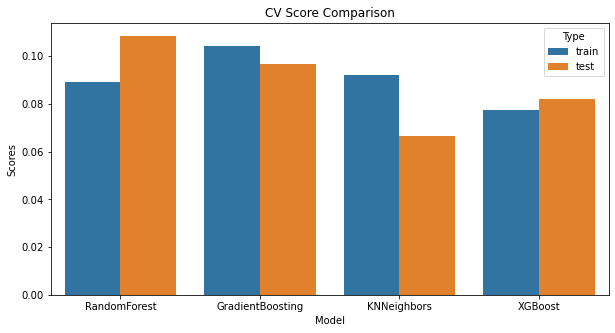

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.subplots(figsize=(10, 5))
sns.barplot(x='Model', y='Scores', hue='Type', data=cv_scores)
plt.title("CV Score Comparison")
plt.show()

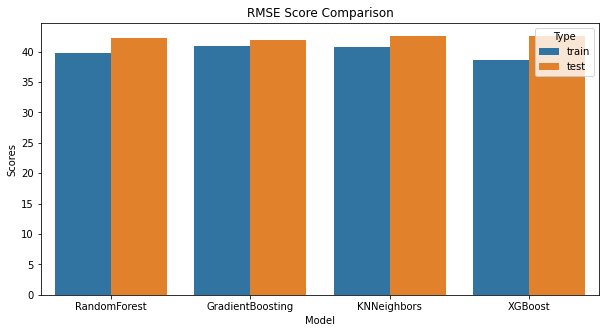

In [67]:
fig=plt.subplots(figsize=(10, 5))
sns.barplot(x='Model', y='Scores', hue='Type', data=rmse_scores)
plt.title("RMSE Score Comparison")
plt.show()

## Conclusion

I'm going to go forward with **GradientBoosting** for the dogs data. I'm choosing this model because it has the best RMSE score for the test set.